In [ ]:
  # setup environment.
%%capture
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastai.vision.all import *
from fastbook import *

In [ ]:
from sklearn.model_selection import StratifiedKFold

  # helper function to create the stratified train/test split.
def train_valid_split(x, y, df, n_splits=5, seed=None, shuffle=True):
  splitter = StratifiedKFold(n_splits=n_splits, random_state=seed, shuffle=shuffle)
  
  trainings = []
  validations = []

    # for each fold, grab a list of the ID's for training and validation.
  for train_idx, valid_idx in splitter.split(x,y):

    train_ids = df['external_id'][train_idx].to_list()
    trainings.append(train_ids)

    valid_ids = df['external_id'][valid_idx].to_list()
    validations.append(valid_ids)

  return trainings, validations



  # helper function to calculate the median likelihood of malignancy.
def calc_median_likelihood(birads_score):
    birads_score = birads_score.lower()
    likelihood_of_malignancy = {
        '3':(0,2),
        '4_a':(2,10),
        '4_b':(10,50),
        '4_c':(50,95),
        '5':(95,100)}

    if birads_score == '2':
      return 0
    else:
      return np.median(np.linspace(likelihood_of_malignancy[birads_score][0],
                                    likelihood_of_malignancy[birads_score][1],
                                    likelihood_of_malignancy[birads_score][1]-likelihood_of_malignancy[birads_score][0]))/100

In [ ]:
# set number of splits for cv training.
k=5

  # set to true to write the output to a csv file.
write_output = False

  # specify features to keep from annotations file.
features_of_interest = ['external_id','pathology','predicted_histology','predicted_birads','shape_acr','orientation','marginal_zone_acr','echo_pattern_acr','posterior_features_acr']

df = pd.read_csv('/content/gdrive/MyDrive/BUS Project Home/Datasets/Mayo/mayo_dataset/annotations_histology.csv')[features_of_interest]

  # set "elevated risk" to "benign".
df['pathology'] = np.where(df['pathology']=='Elevated Risk','Benign',df['pathology'])

  # capitalize the value to make it match actual pathology results.
df['predicted_histology'] = df['predicted_histology'].apply(lambda x: str(x).capitalize())

  # remove unknown pathologies, and missing birads scores.
df = df[df['pathology']!='Unknown']
df = df[df['predicted_birads'].notna()]

  # calculate median likelihood of malignancy based on ranges - do not convert to decimal.
df['median_likelihood_of_malignancy'] = df['predicted_birads'].apply(lambda x: calc_median_likelihood(x))

  # FastAI function to get a list of all pre-cropped image files.
image_urls = get_image_files('/content/gdrive/MyDrive/BUS Project Home/Share_with_group/Jeff_Baggett/bus_data/first_mayo_fastai/images').items

  # for each id (x), find all urls associated with that id and affix it to the dataframe as a list of values.
df['image_url'] = df['external_id'].apply(lambda x: [url for url in image_urls if str(x) in str(url)])

  # remove rows where no image file was found.
df = df[df['image_url'].notna()].reset_index().drop(columns='index')

  # if there is one or more url's listed in the column, then mark it as a multi-image patient id.
df['has_multiple_images'] = df['image_url'].apply(lambda x: False if len(x)<2 else True)

  # create a stratified sample based on if a patient had multiple ids.
trainings, validations = train_valid_split(x=np.zeros(len(df)), 
                                           y=df['has_multiple_images'],
                                           df=df,
                                           n_splits=k, 
                                           seed=516)

  # expand the dataframe where id had multiple images from previous step.
df = df.explode('image_url').reset_index().drop(columns='index')

  # remove rows where no image file was found. Remove the index and multiple images columns since we no longer need that tag.
df = df[df['image_url'].notna()].reset_index().drop(columns=['index','has_multiple_images'])

  # set the fold in which the image belongs in the validation set. Each new column will be referenced during cross-validation training.
for i, valid_ids in enumerate(validations):
    df[f'fold{i}_is_valid'] = df['external_id'].apply(lambda x: 1 if x in valid_ids else 0)

  # write output if true.
if write_output:
    df.to_csv('/content/gdrive/MyDrive/BUS Project Home/Share_with_group/Josh_Jarvey/biradsnet labels/annotations_biradsnet2.csv',index=False)

df.head()

,external_id,pathology,predicted_histology,predicted_birads,shape_acr,orientation,marginal_zone_acr,echo_pattern_acr,posterior_features_acr,median_likelihood_of_malignancy,image_url,fold0_is_valid,fold1_is_valid,fold2_is_valid,fold3_is_valid,fold4_is_valid
0,107342448,Malignant,Malignant,5,irregular,parallel,angular,hypoechoic,shadowing,0.975,/content/gdrive/MyDrive/BUS Project Home/Share_with_group/Jeff_Baggett/bus_data/first_mayo_fastai/images/107342448_malignant_long.png,0,0,1,0,0
1,113014078,Benign,Malignant,4_c,irregular,parallel,circumscribed_,hypoechoic,shadowing,0.725,/content/gdrive/MyDrive/BUS Project Home/Share_with_group/Jeff_Baggett/bus_data/first_mayo_fastai/images/113014078_benign_long.png,0,0,0,1,0
2,121599602,Benign,Malignant,4_a,oval,parallel,circumscribed_,hypoechoic,none,0.060,/content/gdrive/MyDrive/BUS Project Home/Share_with_group/Jeff_Baggett/bus_data/first_mayo_fastai/images/121599602_benign_long.png,0,1,0,0,0
3,126590425,Malignant,Malignant,5,irregular,not_parallel,angular,hypoechoic,shadowing,0.975,/content/gdrive/MyDrive/BUS Project Home/Share_with_group/Jeff_Baggett/bus_data/first_mayo_fastai/images/126590425_malignant_tran.png,0,0,0,0,1
4,128996168,Malignant,Malignant,5,irregular,not_parallel,microlobulated,hypoechoic,shadowing,0.975,/content/gdrive/MyDrive/BUS Project Home/Share_with_group/Jeff_Baggett/bus_data/first_mayo_fastai/images/128996168_malignant_tran.png,0,1,0,0,0


In [ ]:
#@title
# #@title
#   # checking each fold to ensure no overlap in id numbers between train and valid. Also check how pathology was distributed.
# for i in range(k):
#     t = df[df[f'fold{i}_is_valid']==0].external_id.to_list()
#     v = df[df[f'fold{i}_is_valid']==1].external_id.to_list()

#     print(f"Fold {i}:")

#     if any(id in t for id in v):
#       print("there is overlap between train and valid")
#       print(sorted(list(set(v).intersection(t))))
#     else:
#       print("no overlap between train and valid")

#     print("train len: ",len(t))
#     print("valid len: ",len(v))

#     print(df[df[f'fold{i}_is_valid']==1].pathology.value_counts())
#     print("\n")

In [ ]:
class MultiModel(Module):
  def __init__(self, backbone=None, pretrained=True, num_latent = 256):

      # set backbone to pre-trained model, and calculate number of output features from pre-trained model.
    self.backbone = create_body(backbone, pretrained=pretrained)

      # create structure between backbone and tails to generate the common_features 
    self.feature_head = create_head(num_features_model(self.backbone),num_latent)
    
      # simple linear layer for each variable for connecting to the common_features. Input is all shared features (num_latent), output is the softmax of classes for each variable of interest. Count of unique classes for each variable is hard-coded.
    self.shape = nn.Linear(num_latent,3)
    self.orientation = nn.Linear(num_latent,2)
    self.marginal_zone = nn.Linear(num_latent,7)
    self.echo_pattern = nn.Linear(num_latent,7)
    self.posterior_features = nn.Linear(num_latent,4)

      # remaining pieces of complete model
    self.likelihood_of_malignancy = nn.Sequential(
        nn.Linear(num_latent+23,16),
        nn.ReLU(inplace=False),
        nn.Dropout(p=0.5),
        nn.Linear(16,1),
        nn.Sigmoid())

    self.pathology = nn.Sequential(
        nn.Linear(num_latent+24,16),
        nn.ReLU(inplace=False),
        nn.Dropout(p=0.5),
        nn.Linear(16,2))

  def forward(self, x):
      # pass the input data through the backbone network
    y = self.backbone(x)

      # pass the output of the backbone into the feature head. This creates the "shared features map".
    common_features = self.feature_head(y)

      # pass the common features to each variable for prediction.
    shape = self.shape(common_features)
    orientation = self.orientation(common_features)
    marginal_zone = self.marginal_zone(common_features)
    echo_pattern = self.echo_pattern(common_features)
    posterior_features = self.posterior_features(common_features)

      # concat common features with output from all first order variables. This generates likelihood of malignancy. 
    smax = nn.Softmax(dim=1)
    feature_cat2 = torch.cat((common_features, smax(shape), smax(orientation), smax(marginal_zone), smax(echo_pattern), smax(posterior_features)),dim=1)
    likelihood_of_malignancy = self.likelihood_of_malignancy(feature_cat2) 

      # finally, concat the previous feature concatenation with the output from the likelihood of malgnancy, and predict the class.
    feature_cat3 = torch.cat((feature_cat2,likelihood_of_malignancy),dim=1)
    pathology = self.pathology(feature_cat3)

    return [shape,orientation,marginal_zone,echo_pattern,posterior_features,likelihood_of_malignancy,pathology]

In [ ]:
from torch.distributions.beta import Beta

class MultiMixHandler(Callback):
    "A handler class for implementing `MixUp` style scheduling"
    run_valid = False
    def __init__(self,
        alpha:float=0.4 # Determine `Beta` distribution in range (0.,inf]
    ):
        self.distrib = Beta(tensor(alpha), tensor(alpha))

    def before_train(self):
        self.learn.loss_func.mixup = True # turn on mixup for training.
    
    def before_batch(self):
        # Blend xb with another random item in a second batch xb1,yb1 with `lam` weights.
          # Because y is a tuple, get size from 1st element
        if isinstance(self.y,tuple):
            bs = self.y[0].size(0)
        else:
            bs = self.y.size(0)
        
          # randomly generate a lambda (mixup factor) from a beta distribution.
        self.lam = self.distrib.sample((bs,)).squeeze().to(self.x.device)
    
          # select a second observation for mixup.
        self.shuffle = torch.randperm(bs).to(self.x.device)

          #get x values, and find size.
        xb1 = tuple(L(self.xb).itemgot(self.shuffle))
        nx_dims = len(self.x.size())

          # linearly combine the samples.
        self.learn.xb = tuple(L(xb1,self.xb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=nx_dims-1)))

          # set lam and shuffle loss function attributes so yb can be blended in loss function
        self.learn.loss_func.lam = self.lam
        self.learn.loss_func.shuffle = self.shuffle
        
    def before_validate(self):
          # we dont apply mixup to validation.
        self.learn.loss_func.mixup = False

In [ ]:
class MultiTaskLossWrapper(nn.Module):
    def __init__(self, feature_weights = [1,1,1,1,1,1,1], class_weights=[1,1,1,1,1,1,1], class_frequencies=None, mixup = False, lam = None, shuffle = None):
        super(MultiTaskLossWrapper, self).__init__()
        self.feature_weights = feature_weights
        self.class_weights = class_weights
        self.class_frequencies = class_frequencies
        self.mixup = mixup
        self.lam = lam
        self.shuffle = shuffle

    def forward(self, preds, shape, orientation, marginal_zone, echo_pattern, posterior_features, likelihood_of_malignancy, pathology, reduction='none'):

        features = [shape, orientation, marginal_zone, echo_pattern, posterior_features, likelihood_of_malignancy, pathology]
        loss = 0

        if not self.mixup:
            for i, feature in enumerate(features):
              if i == 5:
                loss += self.feature_weights[i]*F.mse_loss(torch.squeeze(preds[i],1), feature)
              else:
                loss += self.feature_weights[i]*F.cross_entropy(preds[i], feature, weight=self.class_weights[i])
        else:
            for i, feature in enumerate(features):
              if i == 5:
                shuffle = L(feature).itemgot(self.shuffle)[0]
                mix = torch.lerp( shuffle, feature, unsqueeze(self.lam,0))
                loss += self.feature_weights[i]*F.mse_loss(torch.squeeze(preds[i],1),torch.squeeze(mix,0))
              else:
                shuffle = L(feature).itemgot(self.shuffle)[0]
            
                  # assign this batch's "base" lambda vector for current feature. Then apply remix to the lambda vector.
                lam_remix = self.lam 
                lam_remix = self.labelMixingFactor(input_samples=feature, shuffle_samples=shuffle, class_frequency=self.class_frequencies[i], lam=lam_remix)

                loss += self.feature_weights[i]*torch.lerp(F.cross_entropy(preds[i],shuffle, weight=self.class_weights[i]),
                                                           F.cross_entropy(preds[i],feature, weight=self.class_weights[i]), 
                                                           lam_remix).mean()
        return loss  

          # implementation of Remix: https://arxiv.org/pdf/2007.03943v1.pdf
    def labelMixingFactor(self, input_samples, shuffle_samples, class_frequency, lam, tau=0.5, kappa=3):
      lam_remix = []

      for i in range(len(input_samples)):

          # pull out the current item from the batch. The items are class numbers, and can be used as indexes into the class_frequency list.
        input_sample = input_samples[i].item()
        shuffle_sample = shuffle_samples[i].item()
        
          # use the current items to lookup class freqencies, calculate the ratio, n_i/n_j (which is base/shuffle)
        ratio = class_frequency[input_sample] / class_frequency[shuffle_sample]
      
          # apply the remix logic to adjust mixing factor (lambda) for the actual linear interpolation step when calculating the loss.
        if ratio >= kappa and lam[i] < tau:
          lam_remix.append(0)
        elif ratio <= 1/kappa and 1-lam[i] < tau:
          lam_remix.append(1)
        else:
          lam_remix.append(lam[i])

      return torch.FloatTensor(lam_remix).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

In [ ]:
  # define metrics for each of the features.
def acc_shape(preds, shape, orientation, marginal_zone, echo_pattern, posterior_features, likelihood_of_malignancy, pathology): return accuracy(preds[0],shape)
def acc_orientation(preds, shape, orientation, marginal_zone, echo_pattern, posterior_features, likelihood_of_malignancy, pathology): return accuracy(preds[1],orientation)
def acc_marginal_zone(preds, shape, orientation, marginal_zone, echo_pattern, posterior_features, likelihood_of_malignancy, pathology): return accuracy(preds[2],marginal_zone)
def acc_echo_pattern(preds, shape, orientation, marginal_zone, echo_pattern, posterior_features, likelihood_of_malignancy, pathology): return accuracy(preds[3],echo_pattern)
def acc_posterior_features(preds, shape, orientation, marginal_zone, echo_pattern, posterior_features, likelihood_of_malignancy, pathology): return accuracy(preds[4],posterior_features)
def rmse_likelihood_of_malignancy(preds, shape, orientation, marginal_zone, echo_pattern, posterior_features, likelihood_of_malignancy, pathology): return rmse(preds[5],likelihood_of_malignancy)
def acc_pathology(preds, shape, orientation, marginal_zone, echo_pattern, posterior_features, likelihood_of_malignancy, pathology): return accuracy(preds[6],pathology)


  # create a combined metric for error, which we look to minimize.
def combined_error(preds, shape, orientation, marginal_zone, echo_pattern, posterior_features, likelihood_of_malignancy, pathology):
    features = [shape, orientation, marginal_zone, echo_pattern, posterior_features, likelihood_of_malignancy, pathology]
    error = sum([rmse(preds[i],feature) if i==5 else error_rate(preds[i],feature) for i, feature in enumerate(features)])
    return error

  # collect all the metrics into a list for the learner.
metrics = [acc_shape, acc_orientation, acc_marginal_zone, acc_echo_pattern, acc_posterior_features, rmse_likelihood_of_malignancy,acc_pathology,combined_error]

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

feature_weights = [2,2,2,2,2,2,5]
class_weights = []
class_frequencies = []
features = ['shape_acr','orientation','marginal_zone_acr','echo_pattern_acr','posterior_features_acr','median_likelihood_of_malignancy','pathology']

  # iterate through each feature: calculate a class weight and count class frequencies. For regression piece, just append 0 as a placeholder.
for feature in features:
    if feature == 'median_likelihood_of_malignancy':
      class_weights.append(0)
      class_frequencies.append(0)
    else:
      ys = df[feature].tolist()
      weight = torch.FloatTensor(compute_class_weight("balanced",classes=np.unique(ys),y=ys)).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
      class_weights.append(weight)

      frequency = torch.IntTensor( np.unique( df[feature].to_list(),return_counts=True)[1]).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
      class_frequencies.append(frequency)

In [ ]:
  # setting up data blocks (types of data), and getters (where it's located).
blocks = (ImageBlock(cls=PILImageBW),
          CategoryBlock(vocab=df['shape_acr'].unique()),
          CategoryBlock(vocab=df['orientation'].unique()),
          CategoryBlock(vocab=df['marginal_zone_acr'].unique()),
          CategoryBlock(vocab=df['echo_pattern_acr'].unique()),
          CategoryBlock(vocab=df['posterior_features_acr'].unique()),
          RegressionBlock(),
          CategoryBlock(vocab=df['pathology'].unique()))

getters = [ColReader('image_url'),
           ColReader('shape_acr'),
           ColReader('orientation'),
           ColReader('marginal_zone_acr'),
           ColReader('echo_pattern_acr'),
           ColReader('posterior_features_acr'),
           ColReader('median_likelihood_of_malignancy'),
           ColReader('pathology')]

  # image augmentation - first is the individual images, then it's what occurs on the batch. FastAI does other augmentations by default (rotate, zoom, etc.).
item_tfms =  [FlipItem(),RandomResizedCrop(256,min_scale=0.8)]
batch_tfms = [*aug_transforms(size=256,
                              do_flip=True,
                              flip_vert=False),
              Normalize.from_stats(*imagenet_stats)]

In [ ]:
from os.path import exists

# This tracker callback triggers when a new best model is found. It writes out the new models metrics, preds, and targets. 

class SaveBestMetrics(TrackerCallback):
    order=TrackerCallback.order+4
    def __init__(self,
        monitor='combined_error', # value being monitored.
        comp=np.less, # numpy comparison operator; np.less if monitor is loss, np.greater if monitor is metric.
        min_delta=0., # minimum delta between the last monitor value and the best monitor value.
        reset_on_fit=True, # before model fitting, reset value being monitored to -infinity (if monitor is metric) or +infinity (if monitor is loss).
        fold=0, # pass in fold to know where to save metrics.
        length=0, # pass in length of each validation set to know where to save preds.
    ):
        super().__init__(monitor=monitor, comp=comp, min_delta=min_delta, reset_on_fit=reset_on_fit)
        self.fold = fold
        self.length = length

    def after_epoch(self):
          super().after_epoch()

          if self.new_best:
            print(f"found new best at epoch {self.epoch}")
            metrics_file_name = '/content/gdrive/MyDrive/BUS Project Home/Share_with_group/Josh_Jarvey/cv results/results_metrics_resnet.csv'
              # put together the name of the metrics and the new best values into a dataframe. self in this scope is the actual learner object.
            best_stats = pd.DataFrame([dict(zip(self.recorder.__dict__['metric_names'],self.recorder.__dict__['log']))])
              # if results file doesnt exist, create it. Otherwise, open the file, and either add the new row for the new fold or update its value with the new best value.
            if not exists(metrics_file_name) or self.fold==0:
              best_stats.to_csv(metrics_file_name,index=False)
            else:
              df_metrics = pd.read_csv(metrics_file_name)          
              if self.fold > len(df_metrics)-1:
                df_metrics = df_metrics.append(best_stats, ignore_index=True)
              else:
                df_metrics.iloc[self.fold] = best_stats
              df_metrics.to_csv(metrics_file_name,index=False)


              # PREDS
            preds_file_name = '/content/gdrive/MyDrive/BUS Project Home/Share_with_group/Josh_Jarvey/cv results/results_preds_resnet.csv'
            preds=self.pred
            df_preds_current = pd.DataFrame()
            
            for j, feature in enumerate(['shape_acr','orientation','marginal_zone_acr','echo_pattern_acr','posterior_features_acr','likelihood of malignancy','pathology']):
              if feature == 'likelihood of malignancy':
                df_preds_current[feature]=[pred.item() for pred in preds[j]]
              elif feature == 'pathology':
                df_preds_current[feature]=self.dls.vocab[j-1][[torch.argmax(smax(pred)).item() for pred in preds[j]]]
              else:
                df_preds_current[feature]=self.dls.vocab[j][[torch.argmax(smax(pred)).item() for pred in preds[j]]]

            if not exists(preds_file_name) or self.fold==0:
              df_preds_current.to_csv(preds_file_name, index=False)
            else:
              df_preds = pd.read_csv(preds_file_name)
              if self.epoch > 0:                
                df_preds = df_preds[:sum([self.length[i] for i in range(self.fold)])]
              df_preds = df_preds.append(df_preds_current, ignore_index=True)
              df_preds.to_csv(preds_file_name, index=False)


              # TARGETS
            targets_file_name = '/content/gdrive/MyDrive/BUS Project Home/Share_with_group/Josh_Jarvey/cv results/results_targets_resnet.csv'
            df_targets_current = self.dls.valid.items[['shape_acr','orientation','marginal_zone_acr','echo_pattern_acr','posterior_features_acr','median_likelihood_of_malignancy','pathology']].reset_index().drop("index",axis=1)

            if not exists(targets_file_name) or self.fold==0:
              df_targets_current.to_csv(targets_file_name, index=False)
            else:
              df_targets = pd.read_csv(targets_file_name)
              if self.epoch > 0:
                df_targets = df_targets[:sum([self.length[i] for i in range(self.fold)])]
              df_targets = df_targets.append(df_targets_current, ignore_index=True)
              df_targets.to_csv(targets_file_name, index=False)


In [ ]:
from torchvision.models.resnet import ResNet34_Weights
net = MultiModel(backbone=resnet34(weights=ResNet34_Weights.IMAGENET1K_V1))

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,acc_shape,acc_orientation,acc_marginal_zone,acc_echo_pattern,acc_posterior_features,rmse_likelihood_of_malignancy,acc_pathology,combined_error,time
0,18.866781,17.775986,0.229167,0.666667,0.125000,0.541667,0.500000,0.414027,0.562500,3.789027,00:04
1,18.895960,17.657928,0.333333,0.666667,0.291667,0.541667,0.416667,0.413118,0.562500,3.600618,00:05
2,18.821600,17.632015,0.291667,0.666667,0.291667,0.541667,0.333333,0.412645,0.562500,3.725145,00:04
3,18.694092,17.503033,0.312500,0.666667,0.291667,0.583333,0.270833,0.413236,0.562500,3.725736,00:06
4,18.553694,17.420881,0.354167,0.687500,0.270833,0.479167,0.229167,0.411503,0.562500,3.828170,00:05
5,18.469271,17.478411,0.416667,0.687500,0.270833,0.395833,0.229167,0.411143,0.562500,3.848643,00:04
6,18.396700,17.505608,0.416667,0.687500,0.270833,0.375000,0.208333,0.410262,0.562500,3.889428,00:05
7,18.341713,17.523975,0.437500,0.666667,0.250000,0.250000,0.208333,0.410194,0.562500,4.035194,00:05
8,18.298965,17.536499,0.500000,0.687500,0.229167,0.187500,0.229167,0.410217,0.562500,4.014383,00:04
9,18.248501,17.571180,0.541667,0.645833,0.208333,0.166667,0.208333,0.410062,0.562500,4.076728,00:05


epoch,train_loss,valid_loss,acc_shape,acc_orientation,acc_marginal_zone,acc_echo_pattern,acc_posterior_features,rmse_likelihood_of_malignancy,acc_pathology,combined_error,time
0,18.242100,17.620827,0.541667,0.625000,0.208333,0.104167,0.187500,0.410691,0.583333,4.160691,00:04
1,18.064236,17.649479,0.520833,0.645833,0.250000,0.125000,0.166667,0.411031,0.583333,4.119364,00:04
2,17.844585,17.673874,0.500000,0.645833,0.208333,0.104167,0.166667,0.410957,0.583333,4.202623,00:04
3,17.789829,17.674417,0.458333,0.666667,0.208333,0.062500,0.166667,0.412320,0.583333,4.266486,00:05
4,17.732134,17.692162,0.479167,0.666667,0.208333,0.083333,0.208333,0.414296,0.583333,4.185129,00:04
5,17.707193,17.749376,0.458333,0.645833,0.187500,0.104167,0.166667,0.415707,0.583333,4.269873,00:04
6,17.715496,17.734333,0.437500,0.625000,0.208333,0.145833,0.187500,0.417539,0.583333,4.230039,00:05
7,17.785444,17.718950,0.416667,0.687500,0.208333,0.166667,0.187500,0.419511,0.562500,4.190344,00:05
8,17.774302,17.704079,0.416667,0.666667,0.291667,0.145833,0.166667,0.420135,0.562500,4.170135,00:04
9,17.840790,17.662424,0.437500,0.645833,0.291667,0.145833,0.166667,0.420209,0.562500,4.170209,00:05


found new best at epoch 0


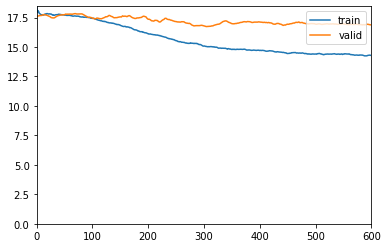

found new best at epoch 1
found new best at epoch 10
found new best at epoch 11
found new best at epoch 12
found new best at epoch 108
found new best at epoch 109
found new best at epoch 132
found new best at epoch 133
found new best at epoch 138
found new best at epoch 139
found new best at epoch 148
found new best at epoch 149
found new best at epoch 150
found new best at epoch 171
found new best at epoch 173


epoch,train_loss,valid_loss,acc_shape,acc_orientation,acc_marginal_zone,acc_echo_pattern,acc_posterior_features,rmse_likelihood_of_malignancy,acc_pathology,combined_error,time
0,18.847651,17.987341,0.434783,0.413043,0.000000,0.260870,0.260870,0.338513,0.543478,4.425469,00:04
1,18.765749,17.917427,0.391304,0.521739,0.043478,0.326087,0.369565,0.337821,0.565217,4.120430,00:04
2,18.574900,17.870958,0.500000,0.521739,0.086957,0.282609,0.304348,0.336837,0.521739,4.119446,00:05
3,18.432617,17.656977,0.565217,0.521739,0.173913,0.347826,0.326087,0.337382,0.565217,3.837382,00:07
4,18.332039,17.521681,0.565217,0.500000,0.130435,0.369565,0.217391,0.339549,0.521739,4.035202,00:04
5,18.264713,17.567299,0.565217,0.586957,0.130435,0.347826,0.260870,0.339032,0.456522,3.991206,00:05
6,18.146894,17.652559,0.565217,0.565217,0.043478,0.260870,0.304348,0.337733,0.456522,4.142081,00:04
7,18.032124,17.611851,0.586957,0.608696,0.086957,0.152174,0.282609,0.337479,0.500000,4.120088,00:05
8,17.993025,17.530144,0.586957,0.608696,0.065217,0.152174,0.260870,0.337536,0.434783,4.228841,00:04
9,17.889246,17.434427,0.673913,0.543478,0.086957,0.173913,0.304348,0.337575,0.456522,4.098445,00:04


epoch,train_loss,valid_loss,acc_shape,acc_orientation,acc_marginal_zone,acc_echo_pattern,acc_posterior_features,rmse_likelihood_of_malignancy,acc_pathology,combined_error,time
0,17.295099,17.375298,0.673913,0.565217,0.152174,0.173913,0.347826,0.338315,0.413043,4.012228,00:05
1,17.282389,17.363613,0.630435,0.543478,0.086957,0.173913,0.282609,0.338839,0.500000,4.121448,00:04
2,17.422934,17.351366,0.652174,0.565217,0.108696,0.173913,0.260870,0.339418,0.565217,4.013330,00:05
3,17.336763,17.319824,0.652174,0.608696,0.130435,0.195652,0.282609,0.339594,0.608696,3.861333,00:05
4,17.415268,17.298403,0.608696,0.586957,0.130435,0.152174,0.260870,0.340552,0.608696,3.992726,00:05
5,17.393707,17.287195,0.565217,0.586957,0.086957,0.130435,0.260870,0.340608,0.630435,4.079738,00:05
6,17.380466,17.241770,0.565217,0.608696,0.086957,0.152174,0.282609,0.340233,0.630435,4.014146,00:04
7,17.364866,17.210785,0.565217,0.586957,0.108696,0.130435,0.260870,0.339826,0.652174,4.035478,00:05
8,17.393181,17.189413,0.586957,0.630435,0.108696,0.152174,0.282609,0.339780,0.630435,3.948475,00:05
9,17.398203,17.184288,0.586957,0.608696,0.130435,0.173913,0.282609,0.339661,0.673913,3.883140,00:04


found new best at epoch 0


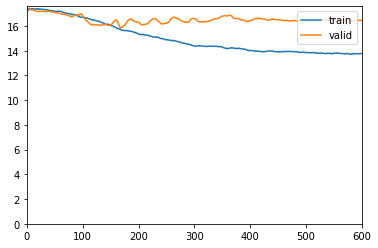

found new best at epoch 3
found new best at epoch 37
found new best at epoch 38
found new best at epoch 39
found new best at epoch 40
found new best at epoch 41
found new best at epoch 43
found new best at epoch 49
found new best at epoch 50
found new best at epoch 51
found new best at epoch 52
found new best at epoch 54
found new best at epoch 55
found new best at epoch 59
found new best at epoch 71
found new best at epoch 80
found new best at epoch 81
found new best at epoch 83
found new best at epoch 86
found new best at epoch 87
found new best at epoch 108
found new best at epoch 118
found new best at epoch 119


epoch,train_loss,valid_loss,acc_shape,acc_orientation,acc_marginal_zone,acc_echo_pattern,acc_posterior_features,rmse_likelihood_of_malignancy,acc_pathology,combined_error,time
0,18.510641,19.169388,0.212766,0.446808,0.021277,0.021277,0.106383,0.448649,0.361702,5.278437,00:04
1,18.664574,19.130325,0.212766,0.510638,0.000000,0.021277,0.170213,0.447285,0.361702,5.170689,00:05
2,18.586332,19.128210,0.382979,0.446808,0.000000,0.021277,0.127660,0.446885,0.361702,5.106460,00:04
3,18.590742,19.227163,0.489362,0.404255,0.000000,0.000000,0.191489,0.446229,0.361702,4.999421,00:04
4,18.558750,19.404844,0.404255,0.404255,0.085106,0.000000,0.170213,0.446016,0.361702,5.020484,00:04
5,18.458553,19.594675,0.297872,0.404255,0.127660,0.000000,0.148936,0.446367,0.361702,5.105941,00:06
6,18.327074,19.762789,0.319149,0.404255,0.148936,0.000000,0.148936,0.444556,0.361702,5.061577,00:05
7,18.230215,20.054806,0.255319,0.446808,0.170213,0.000000,0.170213,0.444220,0.361702,5.039965,00:05
8,18.193771,20.221252,0.170213,0.468085,0.212766,0.000000,0.191489,0.444857,0.361702,5.040602,00:05
9,18.177265,20.267456,0.127660,0.553191,0.170213,0.000000,0.234043,0.445231,0.382979,4.977145,00:05


epoch,train_loss,valid_loss,acc_shape,acc_orientation,acc_marginal_zone,acc_echo_pattern,acc_posterior_features,rmse_likelihood_of_malignancy,acc_pathology,combined_error,time
0,17.674421,20.190334,0.127660,0.553191,0.191489,0.000000,0.234043,0.445778,0.382979,4.956417,00:05
1,17.885433,20.152258,0.106383,0.574468,0.191489,0.021277,0.212766,0.446301,0.382979,4.956940,00:05
2,17.757671,20.058191,0.106383,0.553191,0.148936,0.021277,0.255319,0.445909,0.382979,4.977824,00:05
3,17.745180,19.972523,0.063830,0.553191,0.170213,0.021277,0.255319,0.445800,0.382979,4.998991,00:06
4,17.843767,19.847677,0.063830,0.553191,0.148936,0.042553,0.276596,0.445185,0.340426,5.019653,00:05
5,17.823500,19.687775,0.063830,0.553191,0.148936,0.106383,0.276596,0.444554,0.361702,4.933916,00:04
6,17.885931,19.680424,0.063830,0.553191,0.148936,0.106383,0.255319,0.444472,0.361702,4.955111,00:06
7,17.879978,19.634825,0.063830,0.553191,0.170213,0.106383,0.234043,0.444593,0.361702,4.955232,00:06
8,17.870089,19.592228,0.063830,0.510638,0.170213,0.127660,0.234043,0.444566,0.361702,4.976481,00:08
9,17.873289,19.548359,0.106383,0.510638,0.170213,0.148936,0.234043,0.444819,0.361702,4.912904,00:04


found new best at epoch 0


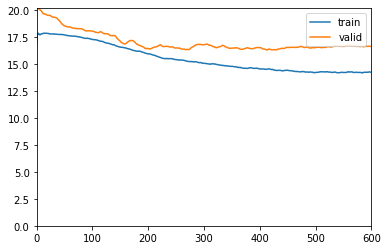

found new best at epoch 5
found new best at epoch 9
found new best at epoch 10
found new best at epoch 11
found new best at epoch 16
found new best at epoch 17
found new best at epoch 18
found new best at epoch 19
found new best at epoch 20
found new best at epoch 22
found new best at epoch 25
found new best at epoch 29
found new best at epoch 31
found new best at epoch 32
found new best at epoch 59
found new best at epoch 61
found new best at epoch 63
found new best at epoch 64
found new best at epoch 65
found new best at epoch 66
found new best at epoch 67
found new best at epoch 68
found new best at epoch 70
found new best at epoch 71
found new best at epoch 73
found new best at epoch 74
found new best at epoch 77
found new best at epoch 87
found new best at epoch 88
found new best at epoch 95
found new best at epoch 96
found new best at epoch 105
found new best at epoch 109
found new best at epoch 113
found new best at epoch 129
found new best at epoch 130
found new best at epoch 1

epoch,train_loss,valid_loss,acc_shape,acc_orientation,acc_marginal_zone,acc_echo_pattern,acc_posterior_features,rmse_likelihood_of_malignancy,acc_pathology,combined_error,time
0,18.699451,17.846405,0.212766,0.531915,0.148936,0.276596,0.297872,0.392578,0.489362,4.435132,00:05
1,18.635458,17.836306,0.340426,0.574468,0.106383,0.276596,0.319149,0.392336,0.468085,4.307230,00:05
2,18.655083,17.997896,0.255319,0.574468,0.085106,0.319149,0.361702,0.391791,0.489362,4.306684,00:05
3,18.579536,18.112051,0.127660,0.510638,0.085106,0.255319,0.255319,0.389918,0.489362,4.666514,00:05
4,18.437475,18.135586,0.127660,0.553191,0.042553,0.212766,0.234043,0.390087,0.531915,4.687959,00:05
5,18.379337,18.268158,0.063830,0.553191,0.042553,0.255319,0.212766,0.391862,0.617021,4.647181,00:04
6,18.285767,18.393509,0.085106,0.595745,0.042553,0.234043,0.234043,0.393146,0.595745,4.605913,00:05
7,18.231375,18.438450,0.106383,0.574468,0.042553,0.212766,0.170213,0.392802,0.595745,4.690675,00:06
8,18.125990,18.485283,0.127660,0.531915,0.085106,0.170213,0.212766,0.393151,0.638298,4.627194,00:04
9,18.021152,18.558744,0.127660,0.510638,0.063830,0.127660,0.191489,0.393525,0.531915,4.840333,00:05


epoch,train_loss,valid_loss,acc_shape,acc_orientation,acc_marginal_zone,acc_echo_pattern,acc_posterior_features,rmse_likelihood_of_malignancy,acc_pathology,combined_error,time
0,17.835032,18.664761,0.191489,0.531915,0.042553,0.127660,0.170213,0.393838,0.574468,4.755541,00:04
1,17.701969,18.699512,0.234043,0.510638,0.042553,0.127660,0.191489,0.393806,0.553191,4.734232,00:04
2,17.694088,18.703850,0.255319,0.468085,0.021277,0.127660,0.191489,0.392873,0.553191,4.775852,00:04
3,17.546926,18.724293,0.255319,0.446808,0.021277,0.127660,0.234043,0.392191,0.531915,4.775170,00:04
4,17.627468,18.784836,0.276596,0.468085,0.042553,0.106383,0.319149,0.391064,0.531915,4.646384,00:04
5,17.575535,18.808809,0.319149,0.489362,0.063830,0.063830,0.340426,0.390359,0.510638,4.603125,00:04
6,17.518677,18.811193,0.340426,0.489362,0.042553,0.063830,0.340426,0.390000,0.553191,4.560213,00:05
7,17.567448,18.817768,0.382979,0.489362,0.021277,0.063830,0.340426,0.389935,0.531915,4.560149,00:04
8,17.579659,18.834284,0.425532,0.489362,0.021277,0.085106,0.319149,0.389922,0.446808,4.602688,00:05
9,17.544062,18.815973,0.382979,0.531915,0.021277,0.085106,0.319149,0.390694,0.446808,4.603461,00:05


found new best at epoch 0


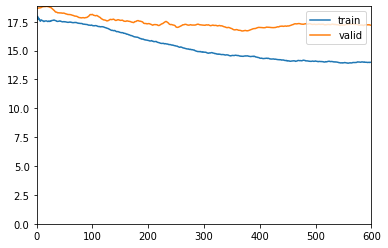

found new best at epoch 1
found new best at epoch 4
found new best at epoch 5
found new best at epoch 6
found new best at epoch 7
found new best at epoch 10
found new best at epoch 16
found new best at epoch 22
found new best at epoch 23
found new best at epoch 25
found new best at epoch 27
found new best at epoch 29
found new best at epoch 30
found new best at epoch 41
found new best at epoch 45
found new best at epoch 49
found new best at epoch 50
found new best at epoch 51
found new best at epoch 54
found new best at epoch 58
found new best at epoch 61
found new best at epoch 62
found new best at epoch 64
found new best at epoch 67
found new best at epoch 78
found new best at epoch 91
found new best at epoch 93
found new best at epoch 94
found new best at epoch 98
found new best at epoch 104
found new best at epoch 105
found new best at epoch 112
found new best at epoch 113
found new best at epoch 115
found new best at epoch 117
found new best at epoch 119
found new best at epoch 12

epoch,train_loss,valid_loss,acc_shape,acc_orientation,acc_marginal_zone,acc_echo_pattern,acc_posterior_features,rmse_likelihood_of_malignancy,acc_pathology,combined_error,time
0,18.610153,18.558804,0.391304,0.500000,0.152174,0.260870,0.369565,0.400376,0.565217,4.161245,00:05
1,18.606855,18.610153,0.434783,0.500000,0.173913,0.282609,0.391304,0.397341,0.565217,4.049515,00:05
2,18.531643,18.576191,0.413043,0.565217,0.195652,0.304348,0.304348,0.394171,0.565217,4.046345,00:08
3,18.470329,18.650948,0.608696,0.456522,0.130435,0.434783,0.391304,0.393179,0.565217,3.806221,00:06
4,18.315430,19.245636,0.630435,0.413043,0.152174,0.456522,0.369565,0.392048,0.565217,3.805092,00:07
5,18.248896,19.061260,0.608696,0.413043,0.152174,0.456522,0.456522,0.394281,0.565217,3.742107,00:04
6,18.131611,18.834812,0.630435,0.478261,0.152174,0.500000,0.434783,0.396385,0.565217,3.635516,00:04
7,17.970158,18.777863,0.630435,0.478261,0.173913,0.478261,0.434783,0.400059,0.565217,3.639189,00:05
8,17.905508,18.770792,0.586957,0.500000,0.152174,0.521739,0.369565,0.403061,0.565217,3.707409,00:05
9,17.770731,18.752182,0.608696,0.521739,0.152174,0.478261,0.326087,0.404756,0.565217,3.752582,00:05


epoch,train_loss,valid_loss,acc_shape,acc_orientation,acc_marginal_zone,acc_echo_pattern,acc_posterior_features,rmse_likelihood_of_malignancy,acc_pathology,combined_error,time
0,17.019911,18.785305,0.608696,0.521739,0.195652,0.521739,0.282609,0.405464,0.565217,3.709812,00:05
1,17.145868,18.826982,0.630435,0.478261,0.130435,0.478261,0.239130,0.405995,0.565217,3.884255,00:04
2,16.898043,18.906319,0.586957,0.456522,0.173913,0.456522,0.217391,0.406078,0.565217,3.949557,00:04
3,16.901922,18.967077,0.608696,0.434783,0.152174,0.500000,0.217391,0.405240,0.565217,3.926979,00:05
4,16.904579,19.028250,0.586957,0.456522,0.152174,0.478261,0.217391,0.404126,0.565217,3.947605,00:05
5,16.953671,19.070669,0.565217,0.456522,0.108696,0.500000,0.217391,0.403046,0.565217,3.990002,00:04
6,17.009192,19.129362,0.565217,0.434783,0.152174,0.478261,0.217391,0.402200,0.565217,3.989157,00:04
7,17.136961,19.157131,0.565217,0.434783,0.130435,0.478261,0.239130,0.401326,0.565217,3.988282,00:05
8,17.169777,19.138058,0.565217,0.456522,0.108696,0.478261,0.260870,0.400836,0.586957,3.944315,00:04
9,17.113194,19.157303,0.586957,0.456522,0.108696,0.391304,0.260870,0.400057,0.586957,4.008752,00:05


found new best at epoch 0


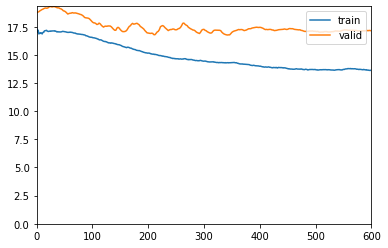

found new best at epoch 46
found new best at epoch 48
found new best at epoch 61
found new best at epoch 67
found new best at epoch 75
found new best at epoch 76
found new best at epoch 77
found new best at epoch 108
found new best at epoch 109
found new best at epoch 167
found new best at epoch 168
found new best at epoch 174
found new best at epoch 191
found new best at epoch 192
found new best at epoch 203
found new best at epoch 207
found new best at epoch 214
found new best at epoch 215
found new best at epoch 216


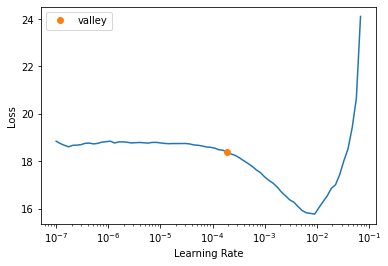

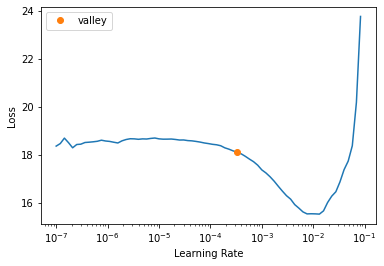

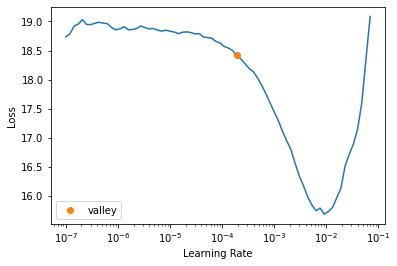

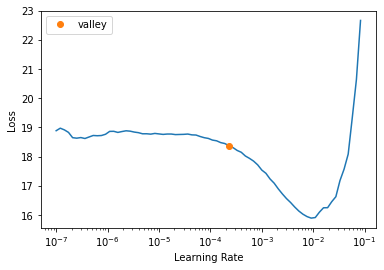

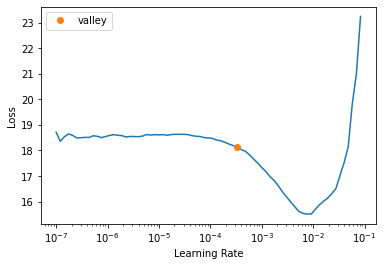

In [ ]:
# k-fold cross-validation training. Each training session uses its own dataloader with the defined validation column

all_preds=[]
all_targets=[]
smax = nn.Softmax(dim=0)
len_valid = [len(df[df[f'fold{i}_is_valid']==1]) for i in range(k)] # get the length of each fold's validation set. This is used in the callback to know where to write up best new results.


for i in range(k):

    # create current fold's datablock.
  bus = DataBlock(blocks=blocks,
                  getters=getters,
                  splitter=ColSplitter(col=f'fold{i}_is_valid'),
                  item_tfms=item_tfms,
                  batch_tfms=batch_tfms,
                  n_inp=1)
  dls = bus.dataloaders(df)

    # create model.
  net = MultiModel(backbone=resnet34(weights=ResNet34_Weights.IMAGENET1K_V1))
  
    # find initial best learning rate. 
  loss_func = MultiTaskLossWrapper(feature_weights=feature_weights,class_weights=class_weights,class_frequencies=class_frequencies,mixup = False)
  learn = Learner(dls, net, loss_func=loss_func, metrics=metrics)
  lr = learn.lr_find()

    # now perform the training using mixup.
  loss_func = MultiTaskLossWrapper(feature_weights=feature_weights,class_weights=class_weights,class_frequencies=class_frequencies,mixup = True) 
  learn = Learner(dls, net, loss_func=loss_func, metrics=metrics)

    # fit inital model heads. Then unfreeze and fit entire model
  learn.fit_one_cycle(10, lr.valley, cbs=[MultiMixHandler()])
  learn.unfreeze()
  learn.fit_one_cycle(300, lr_max = slice(lr.valley/400,lr.valley/4), cbs=[ShowGraphCallback(),MultiMixHandler(),SaveBestMetrics(fold=i, length=len_valid)])

In [ ]:
# Code to use for creating the confusion matricies.
df_preds = pd.read_csv('/content/gdrive/MyDrive/BUS Project Home/Share_with_group/Josh_Jarvey/cv results/results_preds_resnet.csv').T
df_targets = pd.read_csv('/content/gdrive/MyDrive/BUS Project Home/Share_with_group/Josh_Jarvey/cv results/results_targets_resnet.csv').T

  #go through each feature and create a confusion matrix
for i in range(len(df_preds)):
  if i==5:continue
  else:
    y_pred=pd.Series(df_preds.iloc[i].to_list(), name = 'Predicted')
    y_true=pd.Series(df_targets.iloc[i].to_list(), name= 'Actual')

    cm = pd.crosstab( y_true,y_pred).reindex(fill_value=0)
    print(cm)
    print("\n")

Predicted  irregular  oval  round
Actual                           
irregular         79    22     13
oval              24    66     22
round              4     3      1


Predicted     not_parallel  parallel
Actual                              
not_parallel            73        17
parallel                42       102


Predicted          angular  circumscribed_  indistinct  microlobulated  none  \
Actual                                                                         
angular                 11               1           4               3     1   
circumscribed_           7              34           4              17    18   
indistinct               5               1           8              11     0   
microlobulated           6               4           5              20     1   
none                     1               2           0               0     1   
not_circumscribed        0               2           0               0     0   
spiculated               4            

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_score, recall_score, accuracy_score

y_pred=[0 if item=='Benign' else 1 for item in df_preds.iloc[6]]
y_target=[0 if item=='Benign' else 1 for item in df_targets.iloc[6]]

metric_funcs=[roc_auc_score,recall_score#i.e. sensitivity
              ,precision_score,f1_score, accuracy_score, average_precision_score]

for func in metric_funcs:
  print(func(y_target,y_pred))

0.7096242584047462
0.7886178861788617
0.7028985507246377
0.7432950191570882
0.7136752136752137
0.6654294803817604


In [ ]:
# Display best metrics found and their averages.

pd.set_option('display.width', 500)
df_cv = pd.read_csv('/content/gdrive/MyDrive/BUS Project Home/Share_with_group/Josh_Jarvey/cv results/results_metrics_resnet.csv'); 
print(df_cv)
print("\n")
print(df_cv.mean())

   epoch  train_loss  valid_loss  acc_shape  acc_orientation  acc_marginal_zone  acc_echo_pattern  acc_posterior_features  rmse_likelihood_of_malignancy  acc_pathology  combined_error                                   time
0    173   14.838082   17.025023   0.520833         0.645833           0.229167          0.104167                0.541667                       0.385459       0.770833        3.572959                                  00:04
1    119   15.012441   16.191195   0.586957         0.826087           0.413043          0.239130                0.652174                       0.291602       0.782609        2.791601  0    00:05\nName: time, dtype: object
2    213   14.454055   16.335943   0.723404         0.808511           0.297872          0.340426                0.574468                       0.367778       0.744681        2.878416  0    00:05\nName: time, dtype: object
3    257   14.012199   17.241396   0.638298         0.808511           0.361702          0.297872           

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """


In [ ]:
  # Gauge performance of a trained radiologist using the predicted histology data point.

from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_score, recall_score, accuracy_score

  # Build confusion matrix.
y_pred=df.predicted_histology.apply(lambda x: x.capitalize())
y_true=df.pathology

cm = pd.crosstab( y_true,y_pred).reindex(fill_value=0)
print(cm)
print('\n')

  # Calculate additional performance metrics.
y_pred=[0 if item=='Benign' else 1 for item in y_pred]
y_true=[0 if item=='Benign' else 1 for item in y_true]

metric_funcs=[f1_score,recall_score,#i.e. sensitivity
              precision_score,roc_auc_score, accuracy_score, average_precision_score]

for func in metric_funcs:
  print(func(y_true,y_pred))

predicted_histology  Benign  Malignant
pathology                             
Benign                   33         78
Malignant                 8        115


0.7278481012658228
0.9349593495934959
0.5958549222797928
0.6161283234453966
0.6324786324786325
0.5912881647748323
